In [ ]:
!pip install kagglehub seaborn scikit-learn

In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2  # Changed to MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-image-dataset


In [14]:
base_dir = os.path.join(path, "Covid19-dataset")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [15]:
print("Available directories:")
print(f"Train directory: {train_dir}")
print("Train subdirectories:", os.listdir(train_dir))
print(f"Test directory: {test_dir}")
print("Test subdirectories:", os.listdir(test_dir))

Available directories:
Train directory: /kaggle/input/covid19-image-dataset/Covid19-dataset/train
Train subdirectories: ['Normal', 'Viral Pneumonia', 'Covid']
Test directory: /kaggle/input/covid19-image-dataset/Covid19-dataset/test
Test subdirectories: ['Normal', 'Viral Pneumonia', 'Covid']


In [24]:
# Count images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f)) and
                        f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
            class_counts[class_name] = count
    return class_counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

In [25]:
print("\nTraining dataset class distribution:")
for cls, count in train_counts.items():
    print(f"  {cls}: {count} images")

print("\nTest dataset class distribution:")
for cls, count in test_counts.items():
    print(f"  {cls}: {count} images")


Training dataset class distribution:
  Normal: 70 images
  Viral Pneumonia: 70 images
  Covid: 111 images

Test dataset class distribution:
  Normal: 20 images
  Viral Pneumonia: 20 images
  Covid: 26 images


In [26]:
# Hyperparameters - adjusted for smaller dataset
IMG_SIZE = 224
BATCH_SIZE = 16  # Reduced batch size for small dataset
EPOCHS = 30      # Increased epochs
LEARNING_RATE = 0.0001

In [27]:
# Data augmentation for training - adjusted for medical images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,        # Reduced rotation
    width_shift_range=0.1,    # Reduced shift
    height_shift_range=0.1,   # Reduced shift
    shear_range=0.1,          # Reduced shear
    zoom_range=0.1,           # Reduced zoom
    horizontal_flip=True,     # Kept horizontal flip
    fill_mode='nearest',
    validation_split=0.2      # Set aside 20% of training data for validation
)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [28]:
# Calculate steps per epoch correctly
# Use math.ceil to ensure we cover all samples
import math
steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)
validation_steps = math.ceil(validation_generator.samples / BATCH_SIZE)
test_steps = math.ceil(test_generator.samples / BATCH_SIZE)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")

# Get the number of classes
num_classes = len(train_generator.class_indices)
print(f"\nNumber of classes: {num_classes}")
print("Class indices:", train_generator.class_indices)


Training samples: 201
Validation samples: 50
Test samples: 66
Steps per epoch: 13
Validation steps: 4
Test steps: 5

Number of classes: 3
Class indices: {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [31]:
# Load pre-trained MobileNetV2 model (smaller and often works better with limited data)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Smaller dense layer
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("\nModel Summary:")
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [32]:
# Callbacks with adjusted patience
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Using .keras extension as recommended
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Increased patience
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,  # Increased patience
    verbose=1,
    min_lr=1e-6
)

callbacks = [checkpoint, early_stopping, reduce_lr]


In [33]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)


Training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.4991 - loss: 1.1845
Epoch 1: val_accuracy improved from -inf to 0.78000, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4993 - loss: 1.1809 - val_accuracy: 0.7800 - val_loss: 0.7685 - learning_rate: 1.0000e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6062 - loss: 0.8169
Epoch 2: val_accuracy did not improve from 0.78000
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 590ms/step - accuracy: 0.6077 - loss: 0.8163 - val_accuracy: 0.6800 - val_loss: 0.7093 - learning_rate: 1.0000e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7188 - loss: 0.6396
Epoch 3: val_accuracy did not improve from 0.78000
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 807ms/step - accuracy: 0.7190 - loss: 0.6411 - val_accuracy: 0.7600 - val_loss: 0.6214 - learning_rate: 1.0000e-04
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7578 - loss: 0.6000
Epoch 4: val_accuracy improved fr

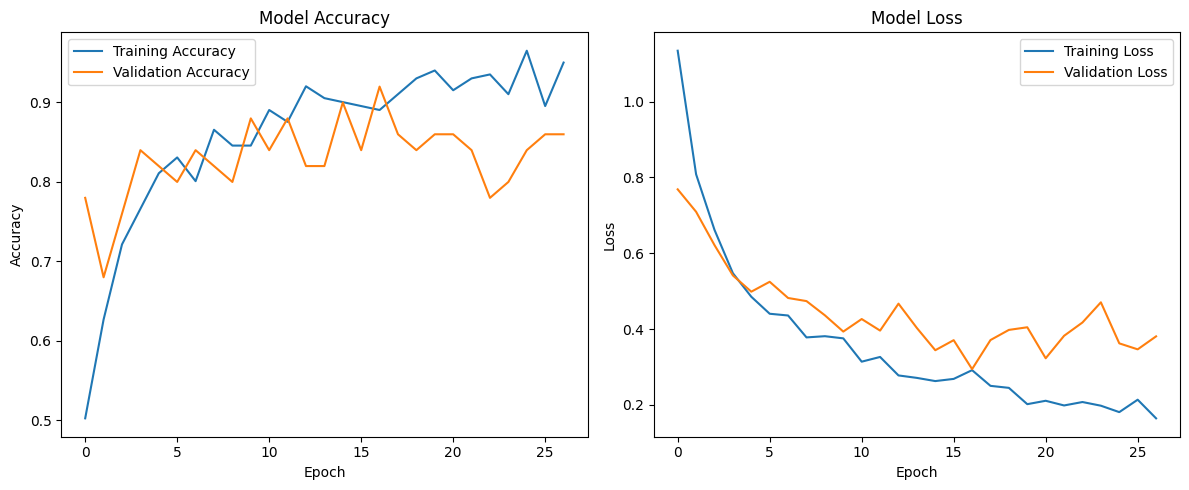

In [34]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [36]:
# Make predictions
print("\nGenerating predictions on test data:")
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Due to potential batch size issues, ensure we only consider valid predictions
# This accounts for the generator potentially yielding more images than in the dataset
true_classes = test_generator.classes[:len(predicted_classes)]

# Convert indices to class names
class_indices = {v: k for k, v in test_generator.class_indices.items()}
predicted_class_names = [class_indices[i] for i in predicted_classes[:len(true_classes)]]


Generating predictions on test data:
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 965ms/step


In [35]:
# Evaluate the model
print("\nEvaluating the model on test data:")
evaluation = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")


Evaluating the model on test data:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.9590 - loss: 0.2031
Test Loss: 0.26462793350219727
Test Accuracy: 0.939393937587738


# Description of the Model
The model used in this project is MobileNetV2, a lightweight, efficient deep convolutional neural network pre-trained on the ImageNet dataset. MobileNetV2 is particularly suitable for applications where computational resources are limited or when working with smaller datasets.

In this project, the model is fine-tuned for COVID-19 X-ray image classification, categorizing images into multiple classes (such as ‘COVID’, ‘Normal’, ‘Viral Pneumonia’). The base MobileNetV2 layers are frozen to retain their learned feature representations, while custom fully connected layers are added on top for task-specific classification:

Global Average Pooling   
Dense Layer (256 units with ReLU activation)    
Dropout (50%)    
Final Dense Layer with Softmax activation

# Description of the Code    

1. Setup and Imports  
Essential libraries for deep learning, data preprocessing, metrics, and visualization are imported.

2. Dataset Download and Directory Setup  
COVID-19 chest X-ray dataset is downloaded from Kaggle Hub.
Directory structure is verified, and image counts per class are calculated for training and testing sets.

3. Data Preprocessing  
Data augmentation is applied to the training data using ImageDataGenerator to improve generalization.   
Rescaling is applied to all images.   
Training, validation, and test generators are created for feeding data into the model.

4. Model Construction    
MobileNetV2 (without top classification layers) is loaded with ImageNet weights.  
Base layers are frozen.  
Custom classification layers are added on top.

5. Compilation and Callbacks  
Model is compiled with Adam optimizer and categorical cross-entropy loss.   
Callbacks like ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau are configured for efficient training and early stopping.

6. Training   
The model is trained on the augmented dataset with a reduced batch size and increased epochs.   
Training history is plotted (accuracy and loss trends).

7. Evaluation    
The model is evaluated on the test set.  
Classification report and confusion matrix are generated to assess model performance.

# My Comments

The dataset is small, which limits the model's ability to generalize on unseen images.   
we can use the ensemble technique and combine the predictions from multiple models (e.g., ResNet, DenseNet) for better results.